In [1]:
#复盘整个过程（修复）

import numpy as np
import pickle
from ddc_pub import ddc_v3 as ddc
import molvecgen
from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED, rdFMCS, RDKFingerprint
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from ipywidgets import interact

import h5py

# 计算子结构相似度
def get_sim(mol, sub_mol) -> float: 
    try:
        res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
        if res.smartsString == "" or res.canceled:
            return 0
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        Chem.SanitizeMol(mcs_mol)

        mcs_mol_fp = RDKFingerprint(mcs_mol)
        sub_mol_fp = RDKFingerprint(sub_mol)
        sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp)

        return sim
    except Exception as e:
        #print(e)
        return 0

# 计算描述符
def get_descriptors(mol, sub_mol) -> list:
    descriptors = []
    if mol:
        try:
            logp = Descriptors.MolLogP(mol)
            tpsa = Descriptors.TPSA(mol)
            sim = get_sim(mol, sub_mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            qed = QED.qed(mol)

            descriptors = [logp, tpsa, sim, qed, hba, hbd]
        except Exception as e:
            #print(e)
            return descriptors
    else:
        print("Invalid generation.")
    return descriptors

# 生成器
class mol_generator:
    def __init__(self, seed_smile:str = "", sub_smile:str = "", model = None, target_names:list = [], qsar_model:str = ""):
        self.mols = []
        self.target = []
        self.target_names = target_names
        self.sani_mols = []
        self.sani_properties = []
        self.data = None
        self.set_seed(seed_smile)
        self.set_sub(sub_smile)
        self.set_model(model)
        self.set_qsar_model(qsar_model)

    def set_seed(self, seed_smile):
        if seed_smile == "":
            return
        #self.seed_smile = seed_smile
        self.seed_mol = Chem.MolFromSmiles(seed_smile)

        print("Seed Molecular:")
        print(Chem.MolToSmiles(self.seed_mol))

    def set_sub(self, sub_smile):
        if sub_smile == "":
            return
        self.sub_mol = Chem.MolFromSmiles(sub_smile)

        print("Substruct:")
        print(Chem.MolToSmiles(self.sub_mol))

    def set_model(self, model):
        if model == "":
            return

        #根据model参数的类型，从文件载入模型或直接接收trainer的模型
        if type(model)==str:
            self.model = ddc.DDC(model_name=model)
        else:
            self.model = model

    def set_qsar_model(self, qsar_model):
        if(qsar_model == ""):
            return
        self.qsar_model = pickle.load(open(qsar_model, "rb"))["classifier_sv"]

    # 检查分子
    def sanitize(self, mol):  
        try:
            Chem.SanitizeMol(mol)
            return mol
        except Exception as e:
            return None
            #print(e)

    # 采样指定性质的分子
    def sample(self, sample_times: int = 4, conditions: list = [None]*6):
        # 确定目标
        #assert len(conditions) >= 7
        self.target = get_descriptors(self.seed_mol, self.sub_mol)
        for i in range(len(conditions)):
            if(conditions[i] != None):
                self.target[i] = conditions[i]
        self.target = np.array(self.target)
        print("Sampling with target:{:}.".format(self.target))
        # 采样
        smiles_out = []
        self.model.batch_input_length = 256  # 太大会减慢速度
        for i in range(sample_times):
            smiles, _ = self.model.predict_batch(latent=self.target.reshape(1, -1), temp=1.0)
            #print("#{:}:{:}".format(i,smiles))
            smiles_out.append(smiles)
        smiles_out = np.concatenate(smiles_out)
        self.mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]
        # 检查分子
        self.sani_mols.clear()
        self.sani_properties.clear()
        for mol in self.mols:
            sani_mol = self.sanitize(mol)
            if sani_mol != None:
                self.sani_mols.append(sani_mol)
                self.sani_properties.append(get_descriptors(sani_mol, self.sub_mol))
        # 打印结果
        print("生成分子数:{:},有效性:{:}".format(
            len(self.mols), len(self.sani_mols)/len(self.mols)))

    # 根据id显示生成的分子
    def showmol(self, i):  
        print(Chem.MolToSmiles(self.sani_mols[i]))
# 筛选sub_similarity==1的分子
    def filter_data(self, filename: str=""):
        #筛选结果
        #print("Saving results.")
        self.binmols = np.asarray([[i.ToBinary() for i in self.sani_mols]])
        self.binmols_data = pd.DataFrame(self.binmols.T, columns=["binmol"], copy=True)
        self.properties_data = pd.DataFrame(self.sani_properties, columns=self.target_names, copy=True)
        self.filtered_data = self.binmols_data.loc[[i==1 for i in self.properties_data["sub_similarity"]]]
        print("Filtered {} mols.".format(len(self.filtered_data["binmol"])))
        #保存文件
        with h5py.File(filename, "w") as f:
            f.create_dataset("mols", data=np.asarray(self.filtered_data["binmol"]))
    
    # 导出数据
    def dump(self, mols_filename:str = "", properties_filename:str=""):
        with open(mols_filename, "wb") as f:
            pickle.dump(self.sani_mols, f)
        with open(properties_filename, "wb") as f:
            pickle.dump(self.sani_properties, f)
    
    def load_data(self, mols_filename:str = "", properties_filename:str=""):
        with open(mols_filename, "rb") as f:
            self.sani_mols = pickle.load(f)
        with open(properties_filename, "rb") as f:
            self.sani_properties = pickle.load(f)
    
    def show_data(self, n=5):  # 以表格形式显示生成的分子的属性
        self.data = pd.DataFrame(self.sani_properties,
                                 columns=self.target_names, copy=True)
        display(self.data.head(n))

    def plot(self):  # 绘制样品分布
        target_dict = {t[0]: t[1] for t in zip(self.target_names, self.target)}
        axes = self.data.hist(bins=25, figsize=(8, 6))
        for i, ax in enumerate(axes.flatten()):
            title = ax.title.__dict__["_text"]
            if title:
                ax.axvline(x=target_dict[title], color='r', linestyle='dashed', linewidth=2)

    def interact(self):  # 显示下拉菜单
        _ = interact(self.showmol, i=range(len(self.sani_mols)))

    # 筛选sub_similarity==1的分子
    def filter_data(self, filename: str=""):
        #筛选结果
        #print("Saving results.")
        self.binmols = np.asarray([[i.ToBinary() for i in self.sani_mols]])
        self.binmols_data = pd.DataFrame(self.binmols.T, columns=["binmol"], copy=True)
        self.properties_data = pd.DataFrame(self.sani_properties, columns=self.target_names, copy=True)
        self.filtered_data = self.binmols_data.loc[[i==1 for i in self.properties_data["sub_similarity"]]]
        print("Filtered {} mols.".format(len(self.filtered_data["binmol"])))
        #保存文件
        with h5py.File(filename, "w") as f:
            f.create_dataset("mols", data=np.asarray(self.filtered_data["binmol"]))
    
    # 导出生成器
    def dump(self, filename:str = ""):
        with open(filename, "wb") as f:
            pickle.dump(self, f)

# 训练器
class model_trainer:
    def __init__(self, is_retrain:bool = False, sub_smile:str = "", model = None, binmols = None):
        self.binmols = []
        self.mols = []
        self.descr = []
        #设置子结构
        self.set_sub(sub_smile)
        #设置描述符和分子
        self.set_binmols(binmols)
        #建立模型
        self.set_model(is_retrain, model)

    def set_sub(self, sub_smile):
        if sub_smile == "":
            return
        self.sub_mol = Chem.MolFromSmiles(sub_smile)
    
    def set_binmols(self, binmols):
        if binmols is None:
            return
        print("Trying to load {} binmols.".format(len(binmols)))
        
        self.binmols = np.asarray(binmols)
        self.mols = np.asarray([Chem.Mol(binmol) for binmol in self.binmols])
        self.descr = np.asarray([get_descriptors(mol, self.sub_mol) for mol in self.mols])

        print("Binmols loaded.")
    
    def set_model(self, is_retrain:bool = False, model = None):
        self.model_name = "new_model"
        if is_retrain:
            if type(model) == str:
                self.model_name = model
                self.model = ddc.DDC(x=self.descr, y=self.binmols, model_name=self.model_name)
            else:
                self.model = model
            print("Loading existing model {}.".format(self.model_name))
        else:
            if type(model) == str:
                self.model_name = model
            self.model = None
            print("Created empty model {}.".format(self.model_name))
    
    # 如果是新模型，需要初始化模型
    def init_model(self, dataset_info=None, scaling=True, noise_std=0.1, lstm_dim=512, dec_layers=3, batch_size = 128):
        if dataset_info is None:
            print("Dataset info not set.")
            return

        self.model = ddc.DDC(x              = self.descr,  # input
                            y              = self.binmols, # output
                            dataset_info   = dataset_info, # dataset information
                            scaling        = scaling,      # scale the descriptors
                            noise_std      = noise_std,    # std of the noise layer
                            lstm_dim       = lstm_dim,     # breadth of LSTM layers
                            dec_layers     = dec_layers,   # number of decoding layers
                            batch_size     = batch_size)   # batch size for training
        print("New model initialized.")

    # 装载训练集
    def fit(self, epochs=300, lr=1e-3, mini_epochs=10, save_period=50, lr_delay=True, sch_epoch_to_start=500, lr_init=1e-3, lr_final=1e-6, patience=25):
        if self.model is None:
            print("Model to fit uninitialized.")
            return
        print("Training model.")

        self.model.fit(epochs              = epochs,                               # number of epochs
                        lr                  = lr,                                  # initial learning rate for Adam, recommended
                        model_name          = self.model_name,                     # base name to append the checkpoints with
                        checkpoint_dir      = "checkpoints_"+self.model_name+"/",  # save checkpoints in the notebook's directory
                        mini_epochs         = mini_epochs,                         # number of sub-epochs within an epoch to trigger lr decay
                        save_period         = save_period,                         # checkpoint frequency (in mini_epochs)
                        lr_decay            = lr_delay,                            # whether to use exponential lr decay or not
                        sch_epoch_to_start  = sch_epoch_to_start,                  # mini-epoch to start lr decay (bypassed if lr_decay=False)
                        sch_lr_init         = lr_init,                             # initial lr, should be equal to lr (bypassed if lr_decay=False)
                        sch_lr_final        = lr_final,                            # final lr before finishing training (bypassed if lr_decay=False)
                        patience            = patience)                            # patience for Keras' ReduceLROnPlateau (bypassed if lr_decay=True)

        print("Training completed.")
    
    # 保存模型
    def save_model(self, filename:str = ""):
        self.model.save(filename)
        print("Model saved.")

    # 导出训练器
    def dump(self, filename:str = ""):
        with open(filename, "wb") as f:
            pickle.dump(self, f)

In [3]:
target_names = ["logp", "tpsa", "sub_similarity", "qed", "hba", "hbd"]      
sub_smiles = "O=C(OC)C1=CC(C2=O)CCCC2C1=O"
seed_smiles = "CC1(C)C(CCC2(C)C1CCC(C34C)(C)C2CC(C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O"

generators = [mol_generator(target_names=target_names, seed_smile=seed_smiles, sub_smile=sub_smiles, model="models/model_0818_{}".format(i)) for i in range(2)]
generators.append(mol_generator(target_names=target_names, seed_smile=seed_smiles, sub_smile=sub_smiles, model="models/model_0818_final"))
#generator.load_data("datasets/generator_0822_m.pickle", "datasets/generator_0822_p.pickle")

Seed Molecular:
COC(=O)C1=C(C)C2(C)CC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C(C)(C1=O)C2=O
Substruct:
COC(=O)C1=CC2CCCC(C1=O)C2=O
Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.
Loading finished in 4 seconds.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 6)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 512), (None, 33792       Latent_Input[0][0]               
_________________________________________

In [4]:
for i in range(3):
    generators[i].sample(4)
    generators[i].show_data()

Sampling with target:[ 4.4719     77.51        1.          0.34974601  5.          0.        ].
生成分子数:1024,有效性:0.751953125


,logp,tpsa,sub_similarity,qed,hba,hbd
0,3.83020,69.67,0.326255,0.336478,5,0
1,4.93790,69.67,0.092664,0.426740,5,0
2,4.36572,69.67,0.588803,0.551181,5,0
3,4.85980,52.60,0.372587,0.513006,4,0
4,4.40710,52.60,0.187259,0.520052,4,0


Sampling with target:[ 4.4719     77.51        1.          0.34974601  5.          0.        ].
生成分子数:1024,有效性:0.8818359375


,logp,tpsa,sub_similarity,qed,hba,hbd
0,5.1016,60.44,0.314672,0.276876,4,0
1,4.5355,77.51,0.760618,0.294366,5,0
2,5.2350,60.44,1.000000,0.274157,4,0
3,3.9220,77.51,1.000000,0.309675,5,0
4,5.0689,60.44,0.793436,0.470751,4,0


Sampling with target:[ 4.4719     77.51        1.          0.34974601  5.          0.        ].
生成分子数:1024,有效性:0.9716796875


,logp,tpsa,sub_similarity,qed,hba,hbd
0,4.3732,94.58,0.621622,0.257309,6,0
1,4.2479,77.51,1.000000,0.490259,5,0
2,4.4719,77.51,1.000000,0.338743,5,0
3,4.2322,77.51,1.000000,0.380026,5,0
4,4.8988,77.51,1.000000,0.321158,5,0


0



Bad key "text.kerning_factor" on line 4 in
d:\Anaconda\Anaconda3\envs\ddc_env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


1
2


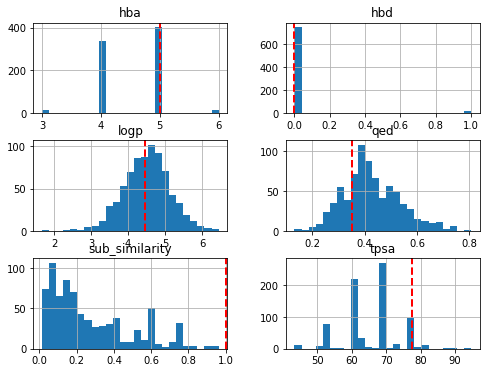

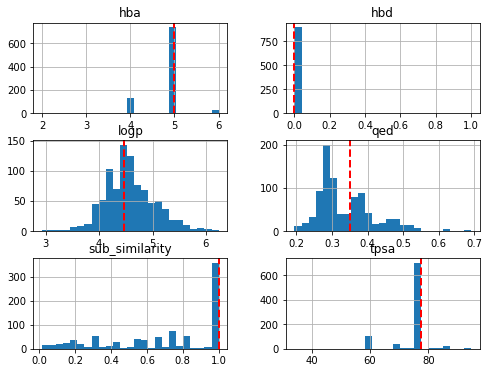

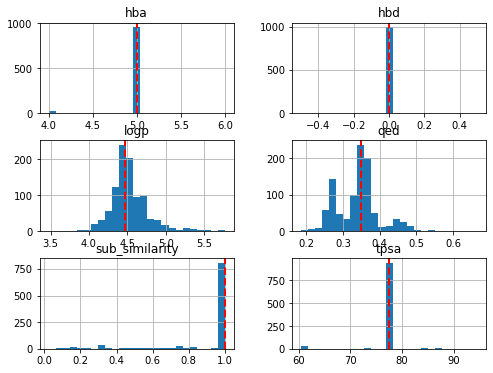

In [5]:
for i in range(3):
    print(i)
    generators[i].plot()

In [8]:
display(generator.data.sort_values("sub_similarity").tail(5))

,logp,tpsa,sub_similarity,qed,hba,hbd
379,4.4939,77.51,1.0,0.430165,5,0
380,4.2259,77.51,1.0,0.352105,5,0
381,4.7242,77.51,1.0,0.254643,5,0
368,4.8620,77.51,1.0,0.349568,5,0
499,4.3278,77.51,1.0,0.350685,5,0


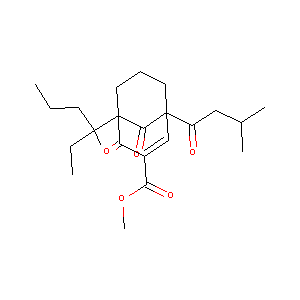

In [11]:
display(Chem.Draw.MolToImage(generators[0].sani_mols[380]))


In [ ]:
generator.interact()